In [1]:
from ms_stim_analysis.Style.style_guide import animal_style
from ms_stim_analysis.Analysis.utils import filter_opto_data
from spyglass.lfp.analysis.v1 import LFPBandV1


from ms_stim_analysis.AnalysisTables.ms_opto_stim_protocol import OptoStimProtocol
import numpy as np
import matplotlib.pyplot as plt

from ms_stim_analysis.Analysis.lfp_analysis import get_ref_electrode_index
from spyglass.common import get_electrode_indices


def circular_statistics(theta):
    X = np.mean(np.cos(theta))
    Y = np.mean(np.sin(theta))
    r = (X**2 + Y**2) ** 0.5
    theta_avg = np.arctan2(Y, X)
    return r, theta_avg

[2025-09-04 16:36:01,514][INFO]: DataJoint 0.14.6 connected to sambray@lmf-db.cin.ucsf.edu:3306


In [ ]:
# # Logging for database export. Not necessary for replication

# from spyglass.common.common_usage import Export, ExportSelection
# paper_key = {"paper_id":"ms_stim_analysis"}

# analysis_id = "rose_plot"
# ExportSelection().start_export(**paper_key, analysis_id=analysis_id)

[17:05:47][INFO] Spyglass: Starting {'export_id': 56}


In [7]:
animal = "transfected"

key = {
    "animal": animal,
    "targeted_phase": 90,
    "min_pulse_length": 20,
    "track_type": "lineartrack",
}

dataset = filter_opto_data(key)

pulse_phase = []
for nwb_file_name, interval_list_name in zip(
    *dataset.fetch("nwb_file_name", "interval_list_name")
):

    lfp_key = {
        "nwb_file_name": nwb_file_name,
        "target_interval_list_name": interval_list_name,
        "filter_name": "Theta 5-11 Hz",
    }

    basic_key = {
        "nwb_file_name": nwb_file_name,
        "target_interval_list_name": interval_list_name,
    }
    ref_elect, basic_key = get_ref_electrode_index(basic_key)  #
    # ref_elect = (Electrode() & basic_key).fetch("original_reference_electrode")[0]
    if not len(band_query := (LFPBandV1 & lfp_key)):
        print(f"No LFP band found for {nwb_file_name} {interval_list_name}")
        continue
    lfp_eseries = (band_query).fetch_nwb()[0]["lfp_band"]
    ref_index = get_electrode_indices(lfp_eseries, [ref_elect])
    ref_index = ref_elect
    try:
        phase_df = (LFPBandV1() & lfp_key).compute_signal_phase([ref_index])
    except Exception as e:
        print(f"Failed to compute phase for {lfp_key}")
        raise e
        continue

    opto_key = {
        "nwb_file_name": nwb_file_name,
        "interval_list_name": interval_list_name,
    }

    stim_val, stim_time = OptoStimProtocol().get_stimulus(opto_key)

    stim = stim_time[stim_val == 1]

    stim_ind = np.digitize(stim, phase_df.index)

    pulse_phase.extend(phase_df.values[stim_ind])
    # break

[17:06:00][WARNING] Spyglass: Cannot export log join for
<class 'ms_stim_analysis.AnalysisTables.ms_opto_stim_protocol.OptoStimProtocolClosedLoop'>


datasets: 11


[2025-09-04 17:06:26,849][WARNING]: Skipped checksum for file with hash: 30b343a6-3902-358c-fc14-865a08a015b9, and path: /stelmo/nwb/raw/Banner20220215_.nwb
[2025-09-04 17:06:31,235][WARNING]: Skipped checksum for file with hash: 1866435c-493a-a23b-8cd4-af6b0ae2bc14, and path: /stelmo/nwb/raw/Banner20220216_.nwb
[2025-09-04 17:06:36,318][WARNING]: Skipped checksum for file with hash: 1f5c50a7-0065-fa56-18eb-45182d0fa2f5, and path: /stelmo/nwb/raw/Frodo20230810_.nwb
[2025-09-04 17:06:41,235][WARNING]: Skipped checksum for file with hash: 6d808fc5-4451-72e0-8008-5d012e52bddf, and path: /stelmo/nwb/raw/Frodo20230811_.nwb
[2025-09-04 17:06:45,097][WARNING]: Skipped checksum for file with hash: f6c16375-eaf3-c123-c6d6-ca6b8bbcc2be, and path: /stelmo/nwb/raw/Odins20220126_.nwb
[2025-09-04 17:06:48,885][WARNING]: Skipped checksum for file with hash: f6c16375-eaf3-c123-c6d6-ca6b8bbcc2be, and path: /stelmo/nwb/raw/Odins20220126_.nwb
[2025-09-04 17:06:53,115][WARNING]: Skipped checksum for file 

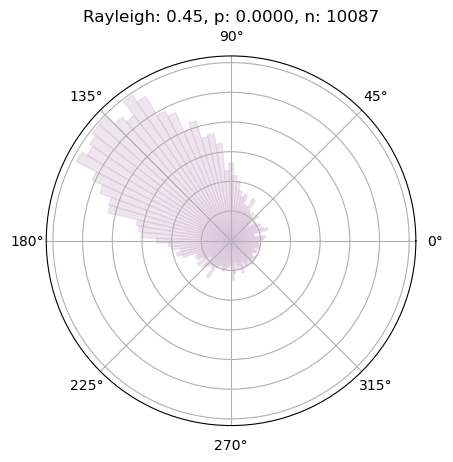

In [ ]:
from scipy import stats

fig = plt.figure()
ax = fig.add_subplot(111, polar=True)

color = animal_style.loc[animal]["color"]
color = "thistle"

freq, theta = np.histogram(pulse_phase, bins=100)
freq = freq / freq.sum()
theta = (theta[1:] + theta[:-1]) / 2
width = np.radians(360 / len(theta))
ax.bar(
    theta,
    freq,
    width=width,
    facecolor=color,
    edgecolor=color,
    alpha=0.4,
    align="edge",
)
ax.set_yticklabels([])

plt.rcParams["svg.fonttype"] = "none"
raleigh, theta_avg = circular_statistics(pulse_phase)

z = raleigh**2 * len(pulse_phase)
p = stats.norm.sf(z)

plt.title(f"Rayleigh: {raleigh:.2f}, p: {p:.4f}, n: {len(pulse_phase)}")

plt.Arrow(0, 0, 0.5, 0.5)
plt.rcParams["svg.fonttype"] = "none"
fig.savefig("../Figures/Fig_S2/Fig_S2a_stim_phase_rose_plot.svg")